# **Kickstarter Campaign Success Prediction**

* **collaborators:** Philipp Becker and Yannic Holländer
* **created**: October 2020

# 1. Introduction

...

# 2. Data Cleaning

In [70]:
import os
import re
import ast

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import cycler

pd.options.display.max_columns = None

color = plt.cm.viridis(np.linspace(0, 1,6))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
#mpl.style.use('fivethirtyeight')

Let's read in the data. The data is split up into multiple .csv-files, so we generate a single dataframe from all of them.

In [2]:
# get current (original) working directory
owd = os.getcwd()

# get all filenames in the data directory
os.chdir(owd+'/data')
all_files = list(filter(os.path.isfile, os.listdir('.')))

# in case there are other files in the directory: 
# define a pattern which all relevant files follow, then make a list of 'valid' files based on their name
regex = re.compile(r'Kickstarter\d+.csv')
valid_files = list(filter(regex.match, all_files))

# read the files and concatenate a single dataframe
df_from_each_file = (pd.read_csv(f) for f in valid_files)
data = pd.concat(df_from_each_file, ignore_index=True)
data.shape

# switch back to original working directory
os.chdir(owd)

First we look at the target variable **state**. There are 5 categories, successful, failed, live, suspended and canceled. Since we want to predict the likelihood of success, we will only consider campaigns that had a regular finish after reaching the deadline (not suspended or canceled). Campaigns that are still live are also of no use to us, so we will drop the corresponding observations.

In [3]:
# drop all rows where state == live/suspended/canceled, these projects are neither successful nor did they fail
data.drop(data[data.state.isin(['live', 'suspended', 'canceled'])].index, inplace=True)
data.shape

(192664, 37)

Interestingly enough, some campaigns seem to have the same **id**:

In [4]:
data.id.value_counts()

1741155109    2
1906255971    2
1170512867    2
2121793969    2
1278991287    2
             ..
1738795055    1
660431949     1
1841033260    1
1515438122    1
1329596417    1
Name: id, Length: 168979, dtype: int64

There seem to be only minor differences between these campaigns with identical **id**. For example, some of them have been launched domestically as well as internationally, but all other 36 aspects are exactly the same. This includes names, campaign urls, goals etc. These doubled campaigns could lead to false conclusions during the EDA or modeling process. 

A possible explanation for duplicated observations could be that the data was aquired by a web crawler in a certain interval, like once a month. This would also explain why the data was split up into 57 data files.

We need to check if those campaigns with the same **id** differ significantly or if they can be considered identical for our puposes. In the second case, we would need to remove the respective duplicate rows. The following function checks for that.

In [5]:
def check_ids(data):
    '''
    Compare rows with the same ID regarding their 'name', 'urls', 'goal', 'launched_at' and 'state' value.
    Return whether some of these rows differ or if they are virtually identical in every case.
    '''
    # get Dataframe of rows with duplicated IDs
    duplicated_campaigns = data[data.duplicated(subset='id', keep=False)]
    
    # for every unique ID check if the 'name', 'urls', 'goals', 'launched_at' and 'state' values are the same
    for ID in set(duplicated_campaigns['id']):
        
        # get the rows with the same ID and the relevant columns
        same_id = data[data['id'] == ID][['name', 'urls', 'goal', 'launched_at', 'state']].to_numpy()
        
        # if the values in both rows are the same we continue the loop
        # else we return that some campaigns with the same ID differ in some aspects
        if (same_id[0] == same_id[1]).all() == True:
            continue
        else:
            return f'Some campaigns of identical ID differ. We need to take a closer look at them. Firs difference at ID {ID}.'
        
    # if we made it through the loop we can assume that the campaigns with the same id are virtually identical
    return 'No fundamental differences between campaigns of identical ID. We can remove all rows with duplicate IDs.'

check_ids(data)

'No fundamental differences between campaigns of identical ID. We can remove all rows with duplicate IDs.'

In [6]:
# According to our function we can safely drop all duplicate ID rows
data.drop_duplicates(inplace=True, subset='id')
data.shape

(168979, 37)

There are 37 columns in this data set. To make the EDA more comfortable we will now drop some columns, either because they have no meaning/significance for our business case, or they are redundant with other columns (risk of multicolinearity). We also need to ensure that the dataframe contains only information that is available at the start of a project (except our target variable **state**). Otherwise, we would be trying to predict whether a project succeeds or fails based on 'future information', like for example the amount of money that was pledged to the campaign.

We eliminate the following columns:

In [7]:
data.drop(axis=1, inplace=True, labels=[
    'permissions',              # only NaN values
    'is_backing',               # only NaN values
    'friends',                  # only NaN values
    'disable_communication',    # only 'False' values
    'is_starrable',             # only 'False' values
    'is_starred',               # only empty values
    'backers_count',            # information not available at start of campaign
    'spotlight',                # information not available at start of campaign
    'staff_pick',               # information not available at start of campaign
    'usd_pledged',              # information not available at start of campaign
    'pledged',                  # information not available at start of campaign
    'currency_symbol',          # redundant with currency
    'slug',                     # redundant with name
    'source_url',               # redundant with category (contains category urls) 
    'state_changed_at',         # redundant with deadline, since we dropped all prematurely ended campaigns
    'currency',                 # largely redundant with (and less detailed than) country
    'currency_trailing_code',   # not relevant for business case
    'profile',                  # contains many values that are also in other columns, too many different profile ids to feasably
    'creator',                  # too many unique values, creating dummy variables not feasable
    'location',                 # creating a dummy variables for each city not feasable (we also already have 'country' for a general location)
    'fx_rate',                  # not relevant for business case, country is already covered by the 'country' variable
    'photo',                    # we will not use image analysis, so no significance for model
    'static_usd_rate',          # data imbalance, also likely not useful to model
    'id',                       # unique campaign identifier not used in modeling
    'converted_pledged_amount', # information not available at start of campaign (also redundant with pledged)
    'current_currency',         # not relevant for business case, country is already covered by the 'country' variable
    'urls'                      # not used in EDA/model           
])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168979 entries, 1 to 209221
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   blurb                   168977 non-null  object 
 1   category                168979 non-null  object 
 2   country                 168979 non-null  object 
 3   created_at              168979 non-null  int64  
 4   currency_trailing_code  168979 non-null  bool   
 5   deadline                168979 non-null  int64  
 6   goal                    168979 non-null  float64
 7   launched_at             168979 non-null  int64  
 8   name                    168979 non-null  object 
 9   state                   168979 non-null  object 
 10  usd_type                168959 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 14.3+ MB


# 3. Exploratory Data Analysis

# 4. Feature Engineering

Now we will format the remaining columns if necessary and do some feature engineering. However, first we will need to create a dummy (numerical) variable from our target variable **state**.

In [8]:
# to make the following work, we will convert the state variable into a dummy variable
dummies = pd.get_dummies(data['state'], drop_first=True)

# concatenate to data
data = pd.concat([data, dummies], axis=1)

# drop original feature
data.drop(labels = ['state'], axis=1, inplace=True)

Onto the feature engineering. We want to make numerical features out of the **category** as explained in the comments of the following code.

In [9]:
# First, copy the current category column, because there are subcategories hidden in there as well
data['subcategory'] = data.category

# Then, get the actual categories from the category-objects 
data.category = data.category.apply(lambda x: ast.literal_eval(x).get('slug')).str.split('/').str[0]

# Now instead of a categorical feature we would like a numerical feature that represents the campaign categories
# This will eliminate the need to create dummy variables for each category and hopefully reduce the training time of our models
# For every category we will calculate the ratio of success and failures, then use this value as a feature
category_success = data.groupby('category')['successful'].mean()
data.category = data.category.apply(func=lambda x: category_success.at[x])

We can also extract the subcategories and do the same to them as well as the **country** column.

In [10]:
# do the same for subcategories
data.subcategory = data.subcategory.apply(lambda x: ast.literal_eval(x).get('slug'))
subcategory_success = data.groupby('subcategory')['successful'].mean()
data.subcategory = data.subcategory.apply(func=lambda x: subcategory_success.at[x])


# do the same for 'country'
country_success = data.groupby('country')['successful'].mean()
data.country = data.country.apply(func=lambda x: country_success.at[x])

Next, we engineer more succinct features out of the different variables containing times and/or dates. In the end, we will have two features remaining. One to describe the time between campaign creation and launch and one that describes for how long the project was open for backers.

In [11]:
# make a new feature "create_to_launch" that measures the time between creation and launch of a project
data['create_to_launch'] = data['launched_at'].sub(data['created_at'], axis=0)

# make a new feature "launch_to_deadline" that measures for how long the project will be open for backers
data['launch_to_deadline'] = data['deadline'].sub(data['launched_at'], axis=0)

Maybe we can also do something with the **name** and **blurb** word count.

In [12]:
# make a new feature "name_length" that counts the number of words in the "name" feature.
data['name_len'] = data.name.str.split().str.len()

# make a new feature "blurb_length" that counts the number of words in the "blurb" feature.
data['blurb_len'] = data.blurb.str.split().str.len()

In [13]:
# lastly, drop remaining NA values
data.dropna(inplace=True)
data.shape

(168957, 16)

Extracting words associated with success or failure from the **blurb** feature.

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

names = data['blurb'].values # an array with entries in the 'blurb' column.

vect = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=1000) # Convert a collection of text documents to a matrix of token counts. stop_words=english removes common engligh words. min_df=1000 sets threshold to a minimum of 1000 occurences per token count.


X = vect.fit_transform(names) # 208508x323 sparse matrix

words = vect.get_feature_names() #Array mapping from feature integer indices to feature name.

y = [x for x in data['successful'].values] # makes a list of the states for each observation

clf = MultinomialNB(alpha=0) # model used
clf.fit(X,y) # fits model

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(), columns=['failed','successful'],index=words) # a dataframe matching the log_probablities that a word is 

likelihood_df = likelihood_df.diff(axis=1) # calculating the difference in probabilities as we don't want words that are associated with both outcomes.
#print(likelihood_df.successful.sort_values(ascending=False).head(30)) # Returns the 30 most "successful words".
#print(likelihood_df.successful.sort_values(ascending=True).head(30)) # Returns the 30 most likely to "fail" words.

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


We make two new features that are true if the blurb contains one of the top 30 success words or one of the top 30 fail words:

In [15]:
data['success_keywords'] = data.blurb.str.contains('enamel|pins|length|comic|debut|edition|rock|ep|recording|band|illustrated|documentary|release|limited|songs|record|fantasy|deck|featuring|album|folk|rpg|releasing|issue|anthology|comics|illustrations|songwriter|recorded|volume',case=False)
data['fail_keywords'] = data.name.str.contains('app|business|mobile|start|food|want|online|trying|social|looking|website|truck|network|news|youtube|service|entertainment|software|platform|sports|provide|organic|events|animated|media|movie|fashion|shop|fresh|people', case=False)

We can also generate two word clouds with our findings.

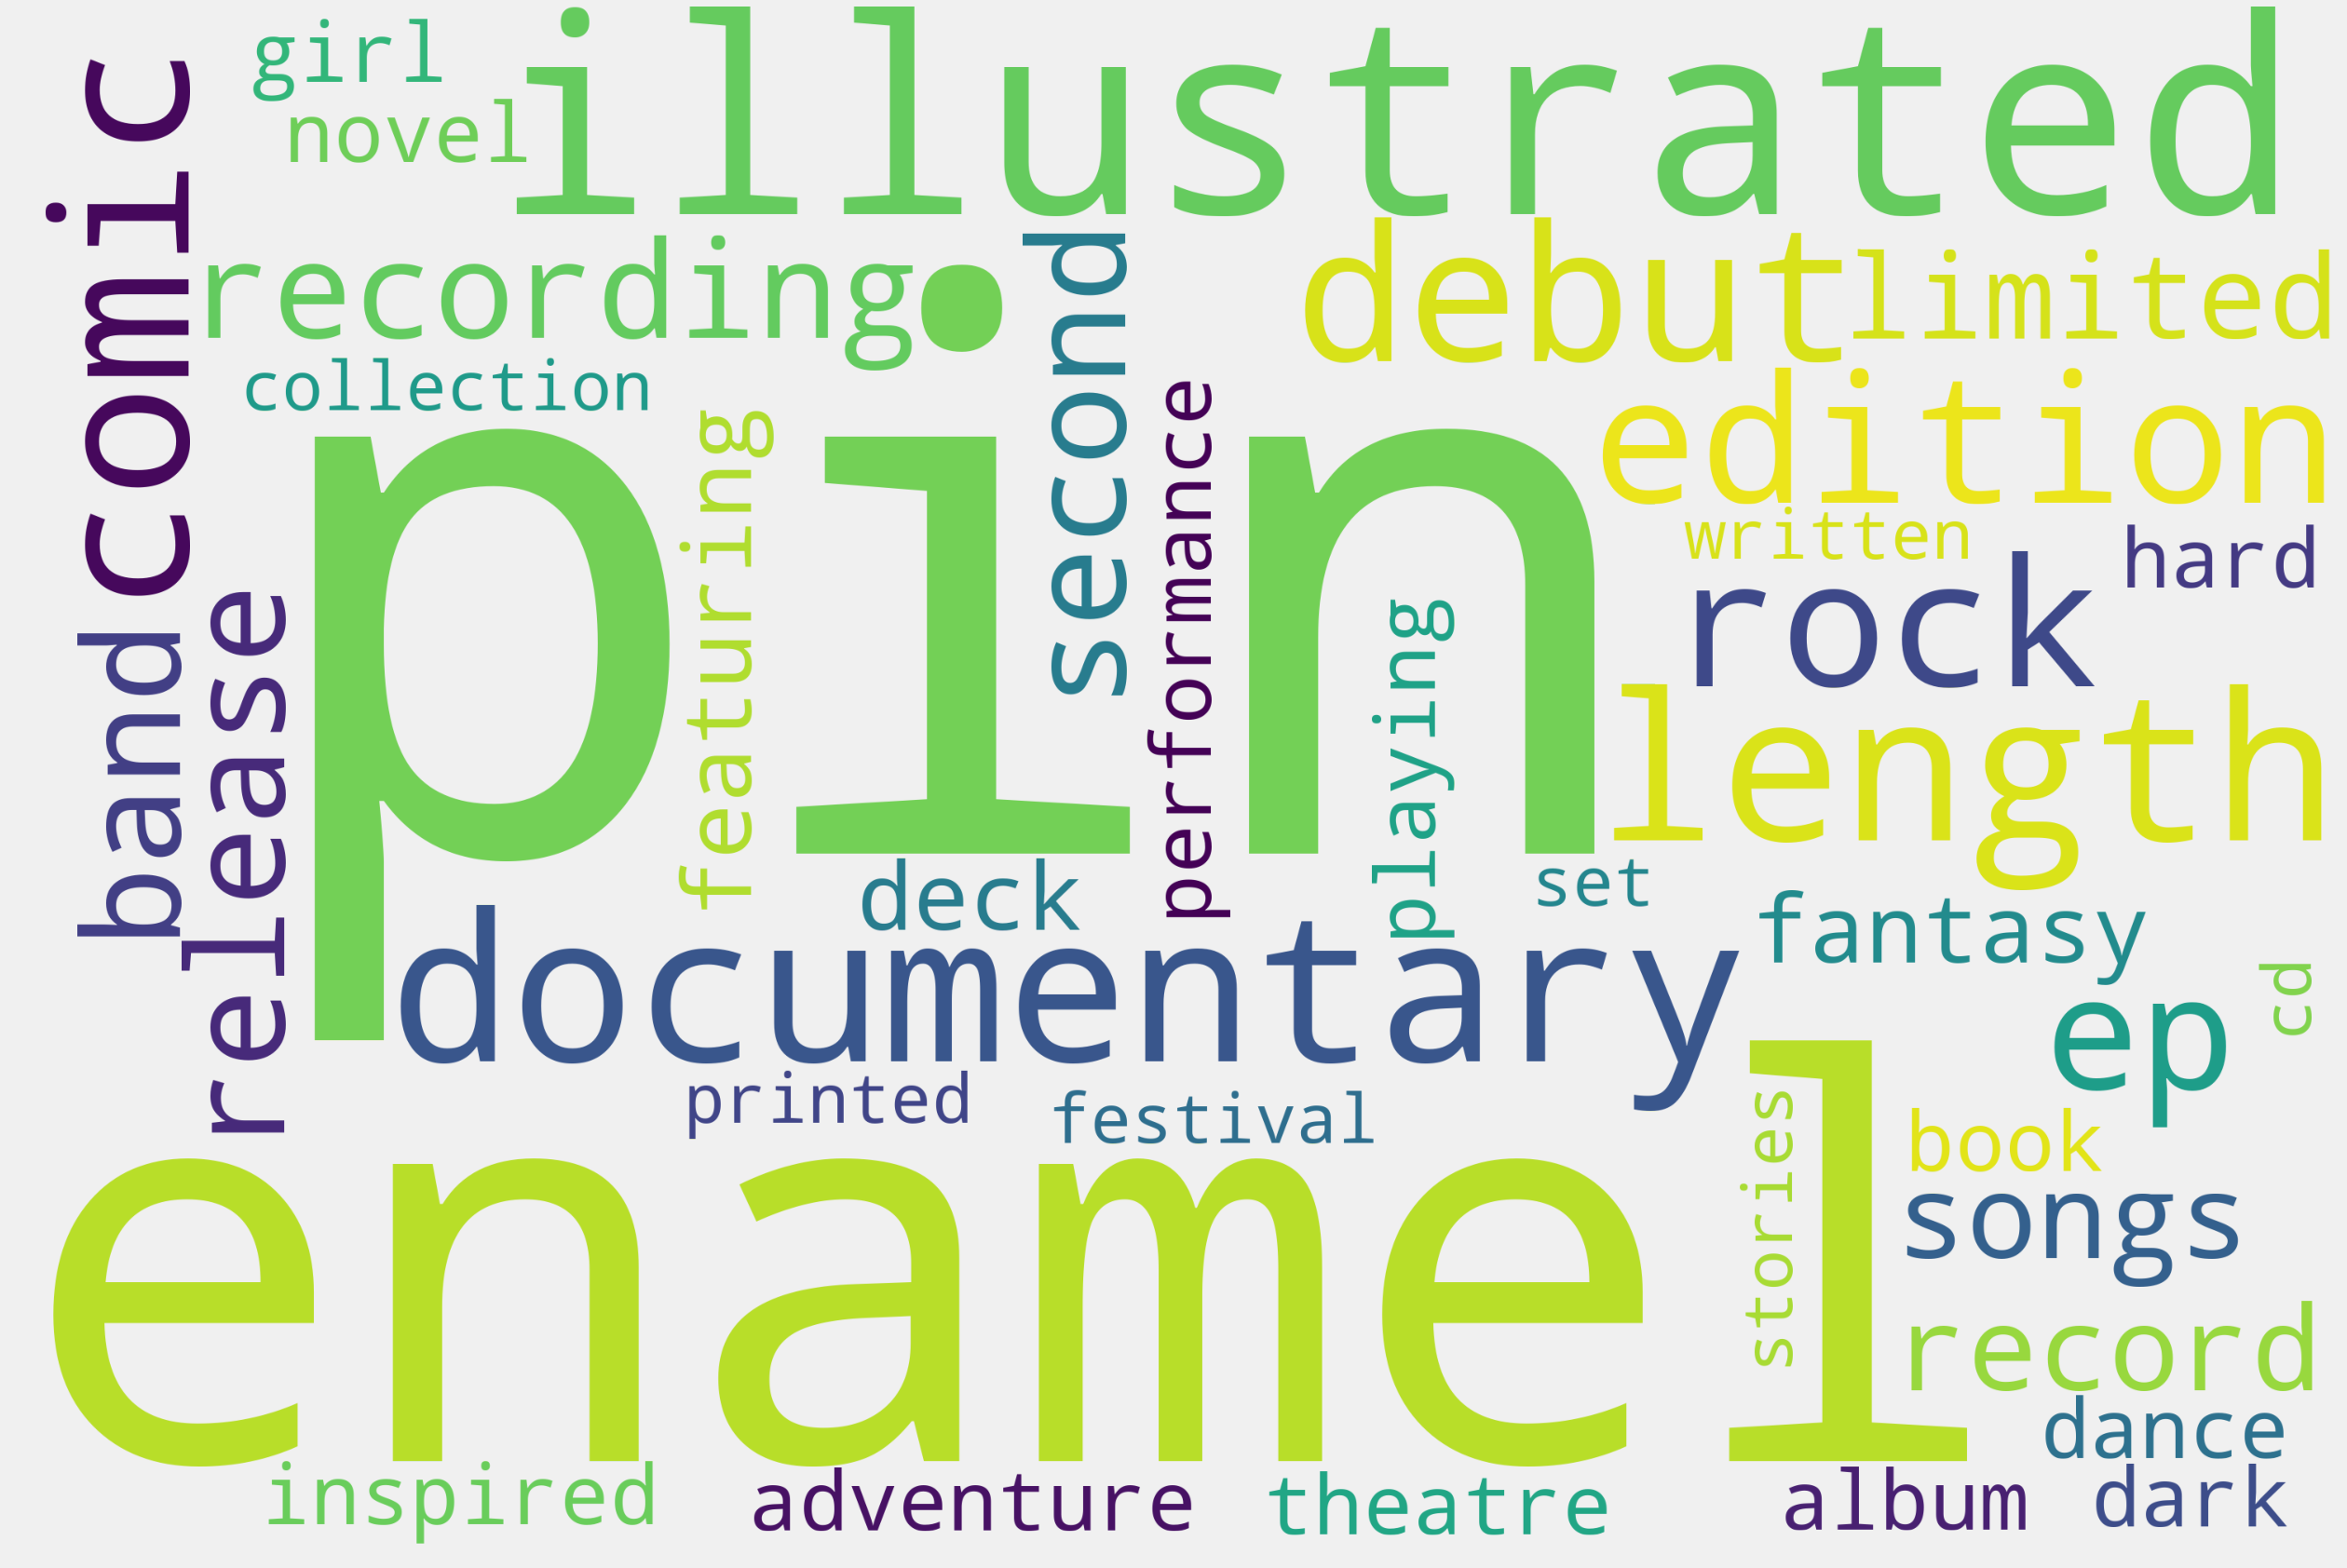

In [241]:
success_weights = likelihood_df.successful.sort_values(ascending=False)[:40].round(2).apply(lambda x: int(x*5))
success_words = likelihood_df.successful.sort_values(ascending=False)[:40].index
fail_weights = likelihood_df.successful.sort_values(ascending=True)[:40].round(2).apply(lambda x: int(x*-5))
fail_words = likelihood_df.successful.sort_values(ascending=True)[:40].index

success_pseudotext = ' '.join(sum([[s] * n for s, n in zip(success_words, success_weights)], []))
fail_pseudotext = ' '.join(sum([[s] * n for s, n in zip(fail_words, fail_weights)], []))

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    

# Generate sucess word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      colormap='viridis', background_color="rgba(255, 255, 255, 0)", mode="RGBA", 
                      collocations=False, min_font_size=80 
                     ).generate(success_pseudotext)

# plot and save
plot_cloud(wordcloud)
wordcloud.to_file('images/Wordcloud_Success.png');

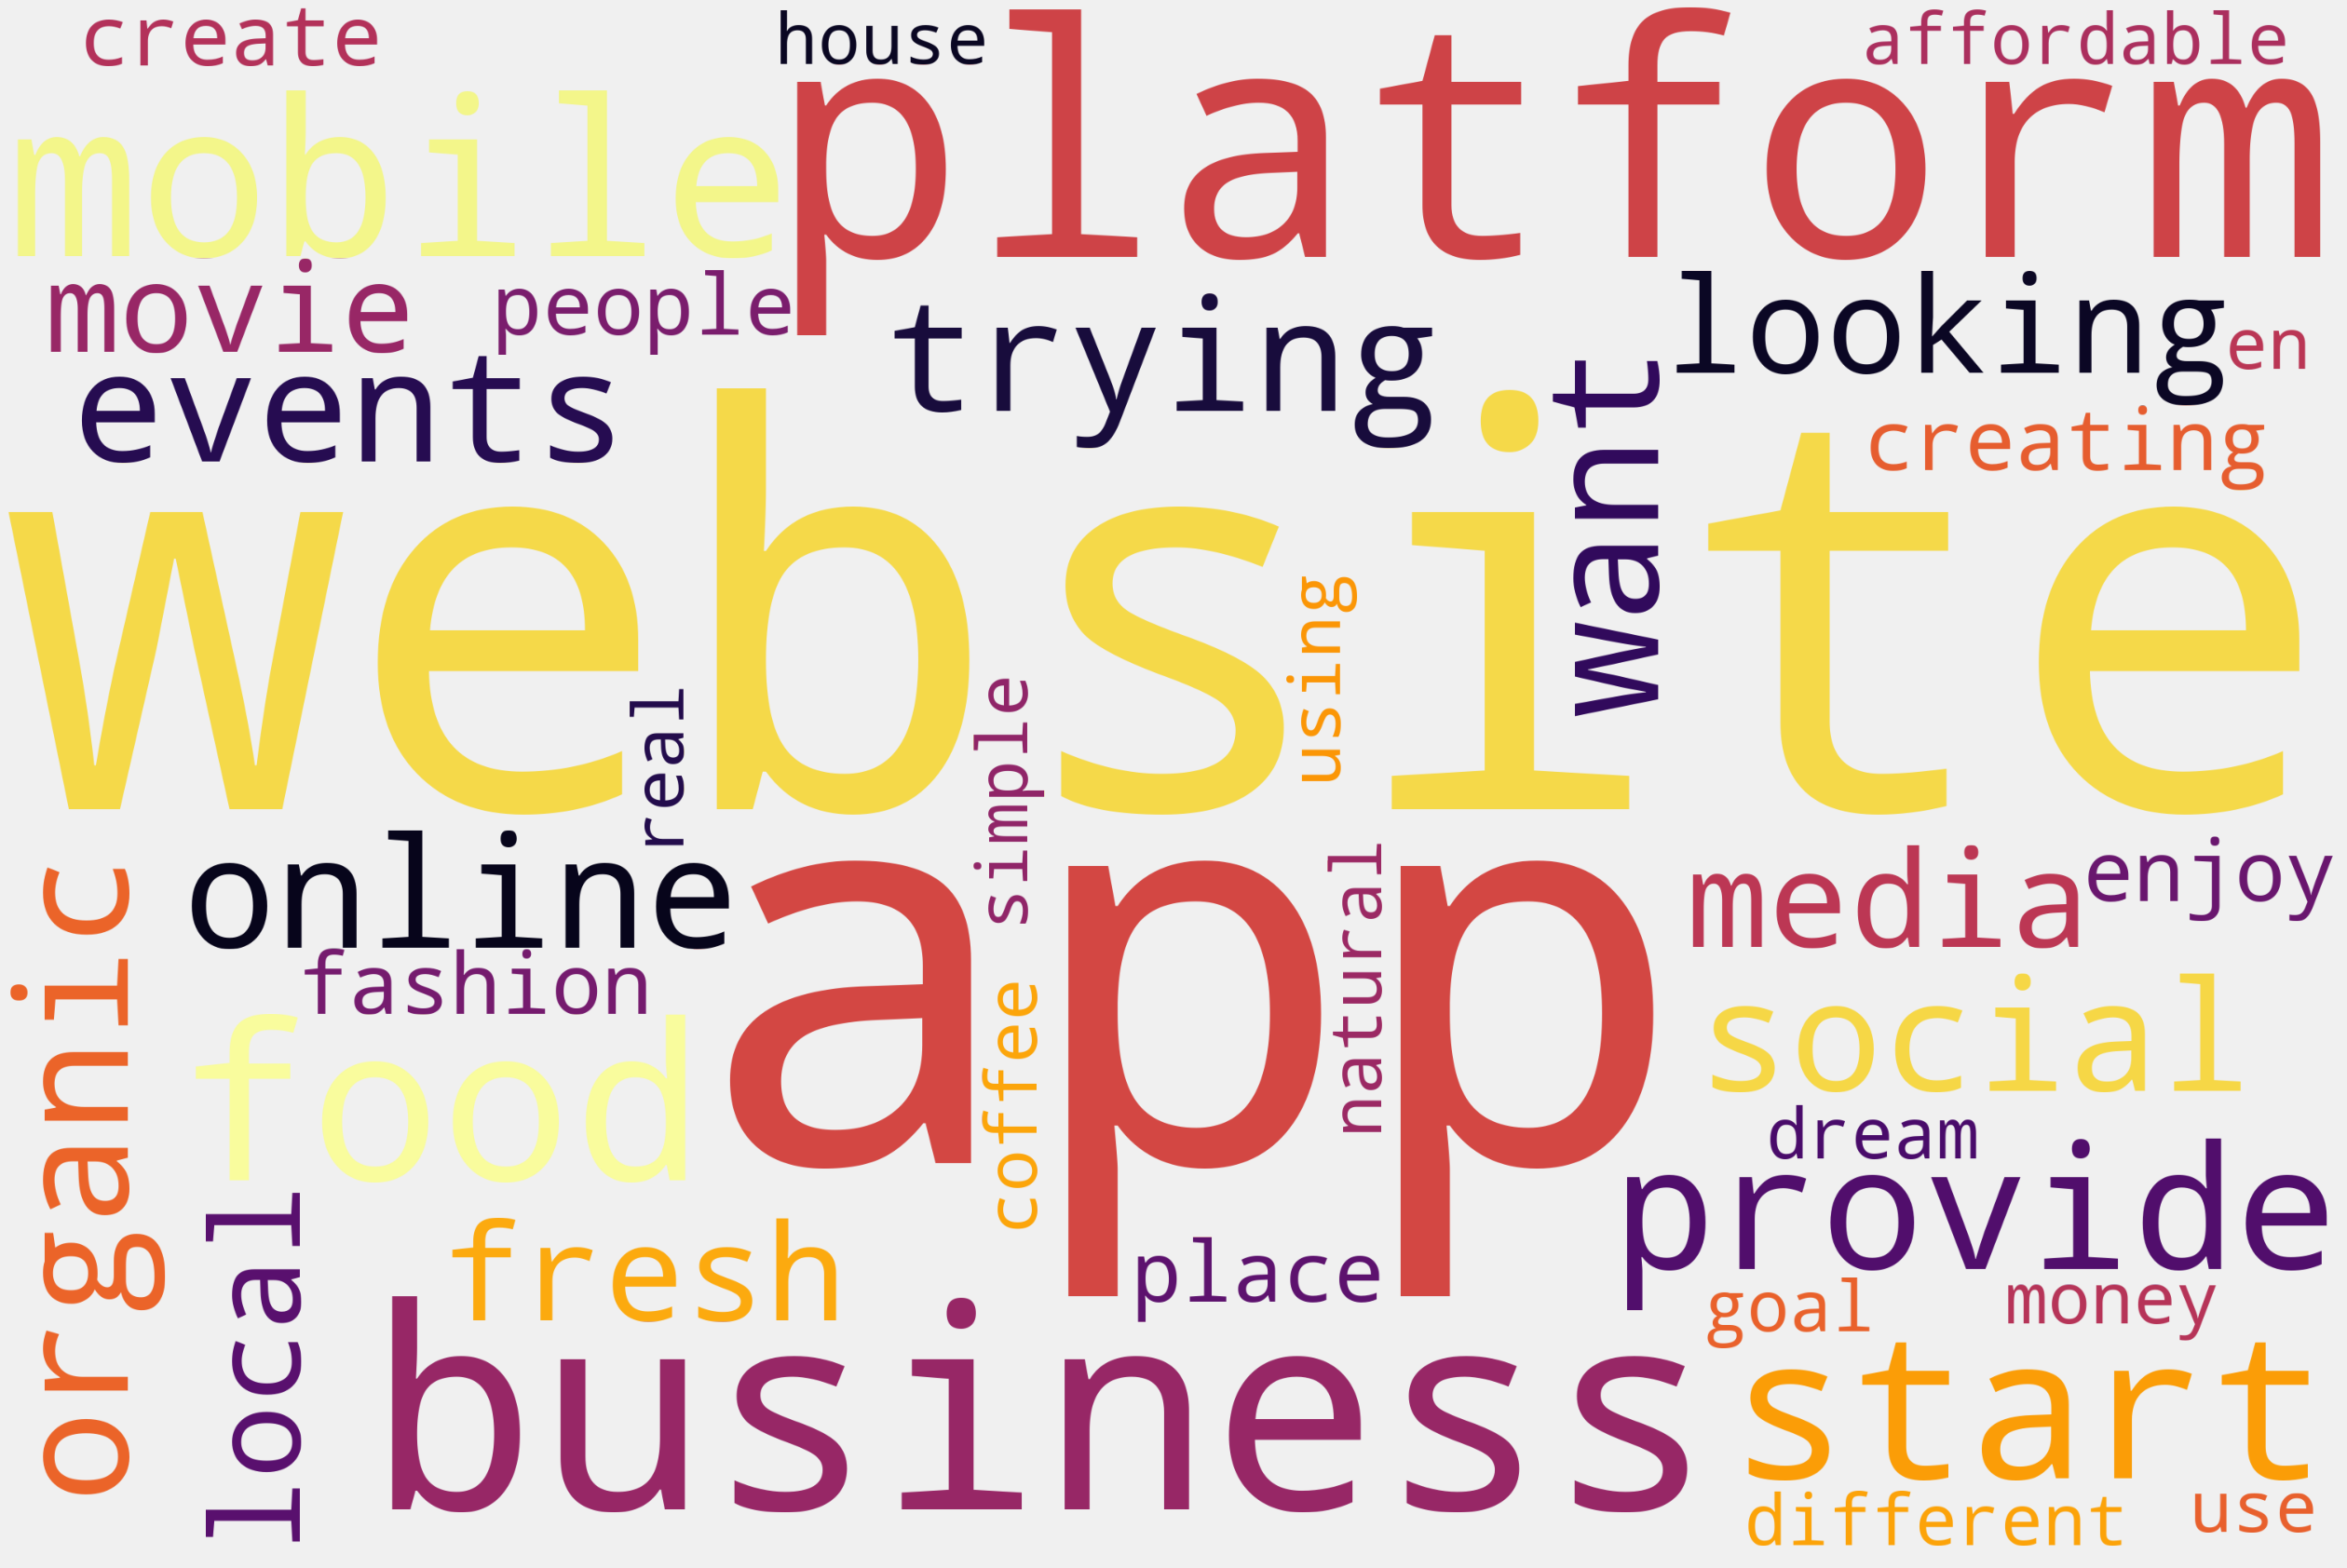

In [242]:
# Generate fail word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color="rgba(255, 255, 255, 0)", mode="RGBA", colormap='inferno_r', 
                      collocations=False, min_font_size=80 
                     ).generate(fail_pseudotext)

# Plot and save
plot_cloud(wordcloud)
wordcloud.to_file('images/Wordcloud_Fail.png');

# 5. Preparation of the modeling process

## 5.1. Set up 

In [18]:
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

Since we want to compare different models, we first set up a dataframe in which the respective evaluation metrics will be saved. We also write a function that is used use to append this dataframe. We only have to call this function once after fitting each model. Later we will then compare all results in a final plot.

In [19]:
# set up a results dataframe in which the scores of all models are compared
results = pd.DataFrame(columns = ['model',
                                  'accuracy_train', 'accuracy_test', 
                                  'f1_score_train', 'f1_score_test', 
                                  'precision_train', 'precision_test'])

# define a function which computes different scores and returns them in a way that we can append to the results dataframe
def model_evaluation(model, X_train, X_test, y_train, y_test, name):
    '''
    Computes relevant scores for a given model and returns them in a specific format.
    The scores are computet for the train set as well as the test set.
    
    inputs:
       - model: the fitted/trained model for which to compute the scores
       - X_train: features training set
       - y_train: target ('state') training set
       - X_test: features testing set
       - y_test: target ('state') testing set
       - name: Name of the model as a string
    '''
    # get predicted values
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # generate dataframe with scores
    results = pd.DataFrame({'model': name,
                            'accuracy_train': accuracy_score(y_train, y_pred_train),
                            'accuracy_test': accuracy_score(y_test, y_pred_test),
                            'f1_score_train': f1_score(y_train, y_pred_train),
                            'f1_score_test': f1_score(y_test, y_pred_test),
                            'precision_train': precision_score(y_train, y_pred_train),
                            'precision_test': precision_score(y_test, y_pred_test)
                           }, index=[0])
    
    return results

Now we do some final preparations to our data. We want to drop all columns that are not predictor or target. We also need to create dummy variables for our categorial data.

In [20]:
# create dummies for the remaining categorial variables and merge them with the dataframe
dummies = pd.get_dummies(data[['usd_type']], drop_first=True)
data = pd.concat([data, dummies], axis=1)
data.shape

# now drop everything we do not need for the modeling process
data.drop(labels = ['usd_type', 'blurb', 'name', 'created_at', 'launched_at', 'deadline', 'category'], axis=1, inplace=True)

## 5.2. Train-Test-Split

The time has come to split our data in a train and test set. At the end we will primarily evaluate the best model of each category on the test set and then chose the one we like best.

In [21]:
y = data['successful']
X = StandardScaler().fit_transform(data.drop('successful', axis=1))

y.value_counts()

1    94759
0    74198
Name: successful, dtype: int64

Since there is roughly the same amount of successful and failed campaigns, we will not counteract data imbalance (stratify, SMOTE or similar techniques).

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print ('Training set has {} samples.'.format(X_train.shape[0]))
print ('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 135165 samples.
Testing set has 33792 samples.


# 6. Model training

We will be fitting and comparing seven different models. One baseline model, three 'simple' models and three 'complex' models. The designtions for 'simple' and 'complex' models are somewhat arbitrary. In our case, boosting and ensemble methods fall under the 'complex' category while the 'simple' models are those that would be easier to understand for newcomers and are typically taught first during machine learning classes. The model types are as follows:

Baseline Model
* Dummy Classifier (most frequent state)

Simple Models
* Logistic Regression
* Gaussian Naive Bayes
* k-nearest Neighbors

Complex Models
* Gradient Boosting Classifier
* Random Forest
* XGBoost

We will will tune the hyperparameters with a cross validated gridearch for the algorithms with a faster training time and a cross validated randomized search for the algorithms with a slower one. How large our parameter grid is and how many models we fit is also dependant on individual training time. This tradeoff is necessary to not go beyond the scope of this project. As this is somewhat of a training exercise for us, we would rather include more of the different models than optimize a single one to its full potential.

## 6.1. Baseline Model

The baseline model will be a DummyClassifier that always predicts the result which is the most frequent in the training data. Later models will be evaluated with the baseline model in mind.

In [23]:
# set up dummy classifier and fit the model
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

# save results
results = results.append(model_evaluation(baseline, X_train, X_test, y_train, y_test, 'baseline'))

## 6.2. Simple Models

### 6.2.1. Logistic Regression

In [24]:
# define grid of parameters for gridsearch
params_logreg = {'penalty':('l1','l2'),
                'C': (0.05, 0.1, 0.3, 0.7, 0.9, 1, 1.1, 10, 100),
                 'solver': ('lbfgs', 'liblinear')
               }

# set up logistic regression classifier and cross validated grid search
logreg = LogisticRegression(max_iter=500)
grid_logreg = GridSearchCV(logreg, param_grid=params_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

# fit the model
grid_logreg.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_logreg.best_params_))

# Save best model as best_model
best_log = grid_logreg.best_estimator_

# save results 
results = results.append(model_evaluation(best_log, X_train, X_test, y_train, y_test, 'logistic regression'))

# note: we will leave the threshold at 0.5 for now and later change it if we decide that the model compares well to the other ones

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.7s finished


Best parameters:
{'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'}


### 6.2.2. Gaussian Naive Bayes

In [25]:
# set up gaussian naive bayes classifier
GNB = GaussianNB()

# there are no hyperparameters to tune, so we just fit the model
GNB.fit(X_train, y_train)

# save results
results = results.append(model_evaluation(GNB, X_train, X_test, y_train, y_test, 'Gaussian NB'))

### 6.2.3. K nearest Neighbors

In [26]:
# define grid of parameters for gridsearch
params_knn = {'metric':('manhattan', 'euclidean', 'minkowski'),
              'n_neighbors': range(10, 81, 5)
               }

# set up kNN classifier and cross validated grid search
knn = KNeighborsClassifier()
grid_knn = RandomizedSearchCV(knn, param_distributions=params_knn, cv=5, scoring='precision', 
                              verbose=10, n_jobs=-1, random_state=0)

# fit the model
grid_knn.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_knn.best_params_))

# Save best model as best_model
best_knn = grid_knn.best_estimator_

# save results
results = results.append(model_evaluation(best_knn, X_train, X_test, y_train, y_test, 'K-nearest neighbors'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.7min finished


Best parameters:
{'n_neighbors': 30, 'metric': 'manhattan'}


## 6.3. Complex Models 
### 6.3.1. Gradient Boosting Classifier

In [27]:
# define grid of parameters for gridsearch
params_gbc = {
    'learning_rate': (0.01, 0.05, 0.1, 0.2, 0.3),
    'min_samples_split': np.linspace(0.1, 0.5, 15),
    'min_samples_leaf': np.linspace(0.1, 0.5, 15),
    'max_depth':(2, 3, 5, 8),
    'max_features':('log2','sqrt'),
    'subsample':(0.5, 0.7, 0.9, 1.0, 1.25, 1.5),
    'n_estimators':(5, 30, 50, 100, 150)
    }

# set up kNN classifier and cross validated grid search
gbc = GradientBoostingClassifier(loss='deviance')
grid_gbc = RandomizedSearchCV(gbc, param_distributions=params_gbc, cv=5, scoring='precision', 
                              verbose=5, n_jobs=-1, random_state=0, n_iter = 100)

# fit the model
grid_gbc.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_gbc.best_params_))

# Save best model as best_model
best_gbc = grid_gbc.best_estimator_

# save results
results = results.append(model_evaluation(best_gbc, X_train, X_test, y_train, y_test, 'Gradient Boosting Classifier'))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


Best parameters:
{'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 0.3571428571428572, 'min_samples_leaf': 0.2142857142857143, 'max_features': 'log2', 'max_depth': 8, 'learning_rate': 0.05}


### 6.3.2. Random Forest

In [28]:
# define grid of parameters for gridsearch
params_rf = {'min_samples_split': (5, 10, 15),
             'max_features': ('auto', 'sqrt'),
             'max_depth': (5, 10, 25, 35),
             'bootstrap': (True, False),
             'min_samples_leaf': (1,2,4),
             'n_estimators': range(50, 301, 50)
               }
# set up support vector machine classifier and cross validated grid search
rf = RandomForestClassifier(random_state = 0)
grid_rf = RandomizedSearchCV(rf, param_distributions=params_rf, cv=5, scoring='precision', 
                             verbose=10, n_jobs=-1, random_state=0)

# fit the model
grid_rf.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_rf.best_params_))

# Save best model as best_model
best_rf = grid_rf.best_estimator_

# save results 
results = results.append(model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.8min finished


Best parameters:
{'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}


### 6.3.3. XGBoost

In [29]:
# define grid of parameters for gridsearch
params_xgb = {
        'min_child_weight': (1, 2, 3),
        'gamma': (0.5, 0,8, 1, 1.2, 1.5),
        'subsample': (0.6, 0.8, 1.0),
        'colsample_bytree': ( 0.8, 1.0, 1.2),
        'max_depth': (5, 6, 7),
        'learning_rate': (0.02, 0.1, 0.15),
        'n_estimators': (400, 600, 800)
        }
# set up support vector machine classifier and cross validated grid search
xgb = XGBClassifier(objective='binary:logistic', njobs=-1)

grid_xgb = RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=3, scoring='precision', 
                             verbose=10, n_jobs=-1, random_state=0, n_iter=15)

# fit the model
grid_xgb.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_xgb.best_params_))

# Save best model as best_model
best_xgb = grid_xgb.best_estimator_

# save results 
results = results.append(model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost'))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 25.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 27.3min finished


Best parameters:
{'subsample': 0.6, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.15, 'gamma': 8, 'colsample_bytree': 0.8}


# 7. Model evaluation
We are done training the different models. Let's take a look at the results:

In [30]:
results.reset_index(drop=True, inplace=True)
results.round(3)

,model,accuracy_train,accuracy_test,f1_score_train,f1_score_test,precision_train,precision_test
0,baseline,0.561,0.560,0.719,0.718,0.561,0.560
1,logistic regression,0.759,0.760,0.781,0.782,0.795,0.794
2,Gaussian NB,0.650,0.649,0.749,0.748,0.627,0.626
3,K-nearest neighbors,0.775,0.760,0.788,0.773,0.838,0.823
4,Gradient Boosting Classifier,0.773,0.774,0.790,0.791,0.820,0.821
5,Random Forest,0.772,0.772,0.786,0.785,0.832,0.832
6,XGBoost,0.817,0.796,0.835,0.816,0.844,0.825


We can visualize the results in a bar plot:

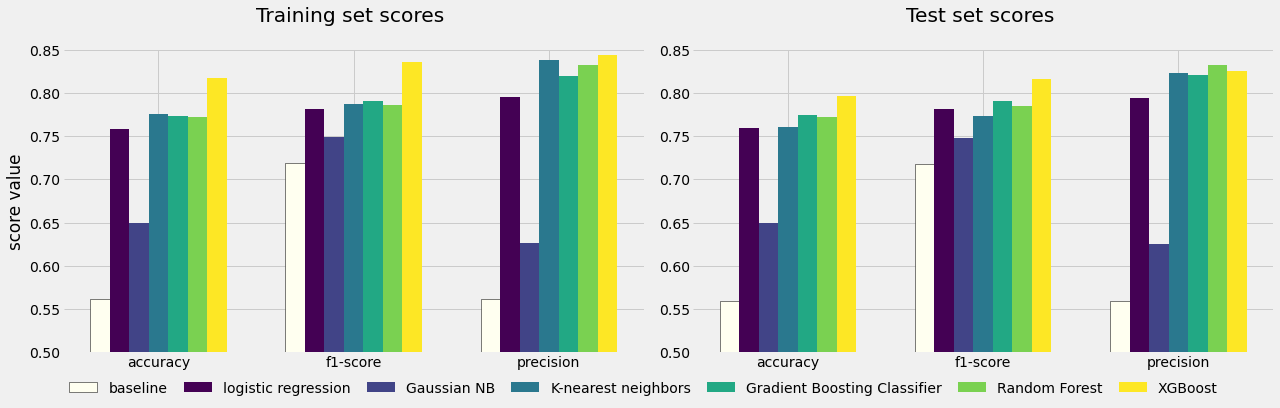

In [236]:
# make two subplots, one for training data and one for test data
fig, ax = plt.subplots(1, 2, figsize = (18,6))

# each sublot will have these three evaluation metrics as a label
labels = ['accuracy', 'f1-score', 'precision']

# specify label locations and bar width
x = 2*np.arange(len(labels))  
width = 0.2  
# fill in both subplots for all models 
for i in range(0,7):
    # for the baseline model (first row with index 0) we want a custom color, so we use an if statement to check for it
    if i == 0:
        # fill in baseline model with custom color
        ax[0].bar((x-3*width), results.iloc[i][1:6:2], width, label=results.model.iloc[i], color='ivory', edgecolor='black')
        ax[1].bar((x-3*width), results.iloc[i][2:7:2], width, label=results.model.iloc[i], color='ivory', edgecolor='black')
    else:
        # the other models are plottet with the standard colormap
        ax[0].bar((x-3*width) + i*width, results.iloc[i][1:6:2], width, label=results.model.iloc[i])
        ax[1].bar((x-3*width) + i*width, results.iloc[i][2:7:2], width, label=results.model.iloc[i])

# add text for labels, title, custom x-axis tick labels
ax[0].set_ylabel('score value')
ax[0].set_title('Training set scores \n')
ax[1].set_title('Test set scores \n')
for i in (0,1):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    ax[i].set_ylim(0.5,0.85)
    ax[i].set_frame_on(False)
    

    
# add one legend for both plots, spanning the width of the entire plot
handles, labels = ax[1].get_legend_handles_labels()
ax[0].legend(bbox_to_anchor=(0, -0.16, 2, .102), loc=3, ncol=7, mode="expand", borderaxespad=0, frameon=False)



# save and show figure 
fig.tight_layout()
plt.savefig('images/Score_Results.png', transparent=True)
plt.show()

In our case XGBoost seems to have the best precision, accuracy and f1-score for the test set. The random forest performs well on the test set and is by far the best for the train set. This difference between sets could indicate some slight overfitting. Thus, we will take the XGBoost model as the final model.

None of the models seem particularly overfitted.

The confusion matrix of this final model looks like this:

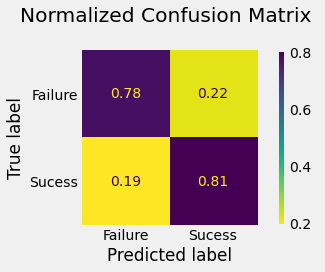

In [234]:
from sklearn.metrics import plot_confusion_matrix

ax = plot_confusion_matrix(best_xgb, X_test, y_test, normalize='true', display_labels = ['Failure', 'Sucess'],
                      cmap='viridis_r')
plt.grid(False)
plt.title('Normalized Confusion Matrix \n')
plt.box(False)
plt.tight_layout()
plt.savefig('images/Confusion_Matrix.png', transparent=True)
plt.show()

Last, we take a look at the feature importances in this final model.

In [180]:
# extract the most important features from our chosen model
importances_values = best_xgb.feature_importances_
# get the feature names from the original dataframe
importances_names = data.drop('successful', axis=1).columns

# gather both in a list of tupels
importances = sorted(zip(importances_names, importances_values), key=lambda x: x[1], reverse=True)
importances

[('subcategory', 0.36864105),
 ('success_keywords', 0.15402952),
 ('goal', 0.08841897),
 ('fail_keywords', 0.07983168),
 ('name_len', 0.059568744),
 ('usd_type_international', 0.047915325),
 ('launch_to_deadline', 0.046849504),
 ('create_to_launch', 0.046448853),
 ('currency_trailing_code', 0.042538766),
 ('country', 0.03713201),
 ('blurb_len', 0.028625578)]

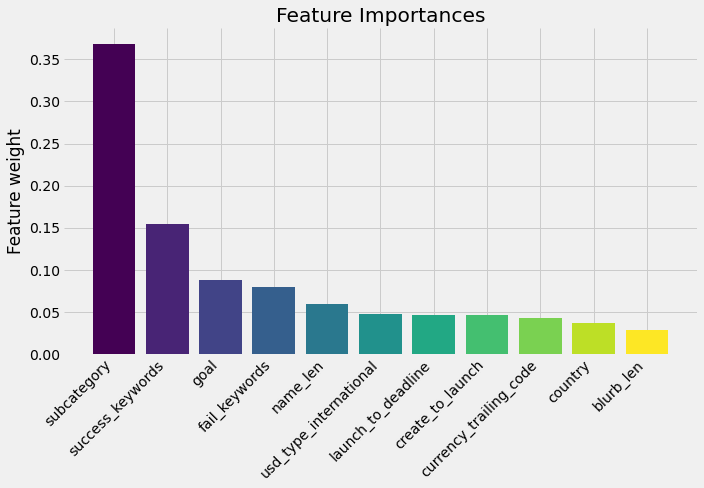

In [214]:
# plot feature importances

feature_names = list(zip(*importances))[0]
feature_values = list(zip(*importances))[1]
x_pos = np.arange(len(feature_names)) 

plt.figure(figsize=(10,7))

plt.bar(x_pos, feature_values, color=plt.cm.viridis(np.linspace(0, 1, len(feature_names))))
plt.title('Feature Importances')
plt.xticks(x_pos, feature_names, rotation=45, ha='right') 
plt.ylabel('Feature weight')
plt.box(False)
plt.tight_layout()
plt.savefig('images/Feature_Importances.png', transparent=True)
plt.show()

Some of our self engineered features seem to be quite important, while others are not that impactful. In a future study of this data set, one could probably make a model with a reduced amount of features that is only neglectably worse or even just as good. 

*NOTE: Normally feature engineering should be done with only the information of the trainig set. In this notebook we engineered features, like for example the importance of words, on the basis of campaign success for the complete data set. If we engineered those features only on the basis of success for the training set, our model might perform slightly worse on the test set.*